# Model

The primary objective of the model is to be able to sort the list of items that a user has purchased in the past in their "buy it again" aisle. So, here we will be predicting if a frequently ordered product or a reordered product will be in user's next purchase. It a binary classification problem, where we will categorise data points into two categories: 1 (reordered) and 0 (not reordered).



**Loading the required Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, cohen_kappa_score
from sklearn.feature_selection import SelectFromModel


!pip install dmba --quiet
from dmba import plotDecisionTree, classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

import warnings #to filter out future warning
warnings.filterwarnings("ignore")

no display found. Using non-interactive Agg backend


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Colab Notebooks/

df = pd.read_pickle("final_data.pkl")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks


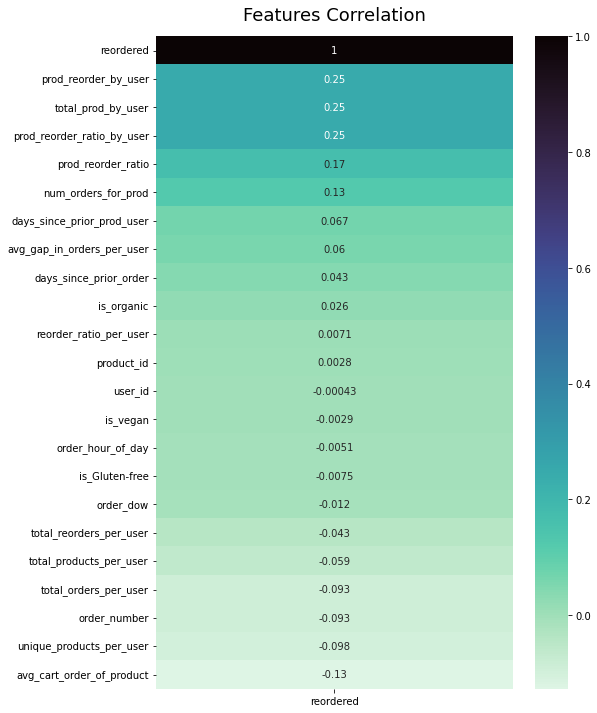

In [ ]:
#visualize the correlation between features and our target
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['reordered']].sort_values(by = 'reordered',ascending=False),  annot=True, cmap='mako_r')
heatmap.set_title('Features Correlation', fontdict={'fontsize':18}, pad=16);

Key Takeaways:


*   Highest Correlation between target and following features:
  * prod_reorder_by_user: Total number of reordered products by user
  * total_prod_by_user: Total number of products ordered by user
  * prod_reorder_ratio_by_user: Ratio of product reorder by user









In [ ]:
#Dropping irrelevant columns 
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

#one hot encoding categorical column such as order day of the week
df['order_dow'] = df['order_dow'].astype('category')
new_categories = {0: 'Saturday', 1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday'}
df.order_dow.cat.rename_categories(new_categories, inplace=True)

df = pd.get_dummies(df, prefix_sep='_', drop_first=True)

In [ ]:
#defining target 

target = 'reordered'
col = df.columns.drop('reordered')

X = df[col]
Y = df[target]

In [ ]:
#dividing dataset into train & test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size = 0.3, random_state=10) 

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(5932262, 25) (5932262,)
(2542399, 25) (2542399,)


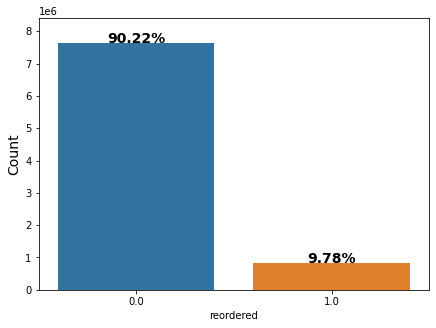

In [ ]:
total = len(df)
plt.figure(figsize=(7,5))
g = sns.countplot(x='reordered', data=df)
g.set_ylabel('Count', fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 1.5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14, fontweight='bold')
plt.margins(y=0.1)
plt.show()

As we can see, dataset is highly imbalanced with 9:1 ratio. With biased or skewed dataset, classification model will have poor predictive performance, especially for minority class. Common combat technique would be to do undersampling or oversampling but in since we have limited RAM, oversampling would not be suitable, so we will do undersampling.

Common techniques of undersamplings are:
* SMOTE (Synthetic Minority Oversampling TEchnique)
* Near Miss Undersampling
* Random undersampling

We will use Random undersampling, since it is managable and feasible within a limited compute.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# undersample strategy = default i.e. equivalent to minory class
undersample = RandomUnderSampler()

In [ ]:
train_x, train_y = undersample.fit_resample(X_train,Y_train)

test_x, test_y = undersample.fit_resample(X_test,Y_test)

In [ ]:
#after randomly undersampling
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1161314, 25) (1161314,)
(496334, 25) (496334,)


In [ ]:
def metrics(prediction):
  
  ''' This function will return accuracy,precision, recall, F1 score and ROC AUC'''

  accuracy = accuracy_score(test_y, prediction)
  f1 = f1_score(prediction,test_y)
  precision = precision_score(prediction,test_y)
  recall = recall_score(prediction,test_y)
  auc = roc_auc_score(prediction,test_y)
  print("Accuracy: {:.4%}".format(accuracy))
  print("Precision: {:.4%}".format(precision))
  print("Recall: {:.4%}".format(recall))
  print("F1 Score: {:.4%}".format(f1))
  print("ROC AUC: {:.4%}".format(auc))


def confusion_matrix_plot(model):

  ''' This function will create a Confusion Matrix plot '''

  fig, ax = plt.subplots(figsize=(8, 8))
  plot_confusion_matrix(model, test_x, test_y, display_labels=["Not Reordered","Reordered"], cmap=plt.cm.Blues,values_format = '.6g', ax = ax)
  plt.title('Confusion Matrix')
  plt.xlabel('\nPredicted Values')
  plt.ylabel('Actual Values ')
  plt.show();

def plot_roc_curve(fper, tper):

  ''' This function will create a ROC curve'''

  plt.figure(figsize=(8,7))
  plt.plot(fper, tper, color='red', label='ROC')
  plt.plot([0, 1], [0, 1], color='green', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend()
  plt.show();

##**Decision Tree** 

In [19]:
dt = DecisionTreeClassifier()

dt.fit(train_x,train_y)

dt_predictions =dt.predict(test_x)

Accuracy: 63.5622%
Precision: 63.9884%
Recall: 63.4476%
F1 Score: 63.7168%
ROC AUC: 63.5632%


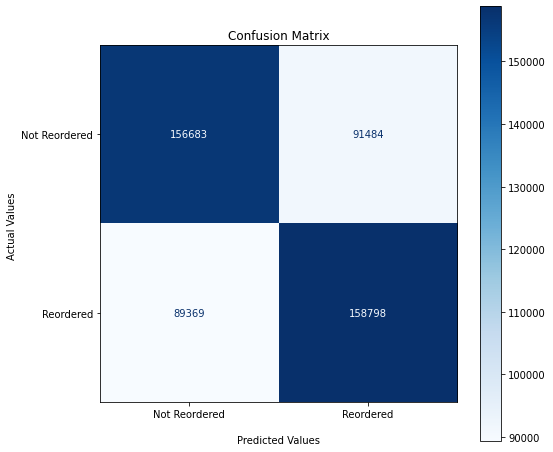

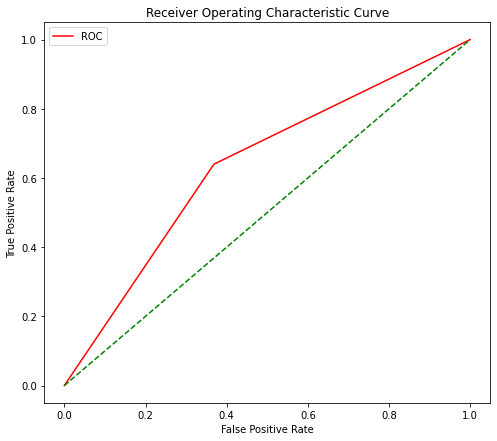

In [20]:
metrics(dt_predictions)

confusion_matrix_plot(dt)

fper, tper, threshold = roc_curve(test_y, dt_predictions)
plot_roc_curve(fper, tper)

In [21]:
#Hyperparameter optimization with RandomizedsearchCV
param_grid = {
    'max_depth': list(range(2, 10)),  
    'min_samples_split': list(range(5, 20)), 
    'min_impurity_decrease': [0, 0.001, 0.0011], 
}

gridSearch = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, cv=5,
                          n_jobs=-1)

gridSearch.fit(train_x, train_y)

print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.720252230681532
Initial parameters:  {'min_samples_split': 9, 'min_impurity_decrease': 0, 'max_depth': 9}


In [22]:
bestClassTree = gridSearch.best_estimator_
bestClassTree_pd = bestClassTree.predict(test_x)

Accuracy: 71.9233%
Precision: 70.9679%
Recall: 72.3504%
F1 Score: 71.6525%
ROC AUC: 71.9313%


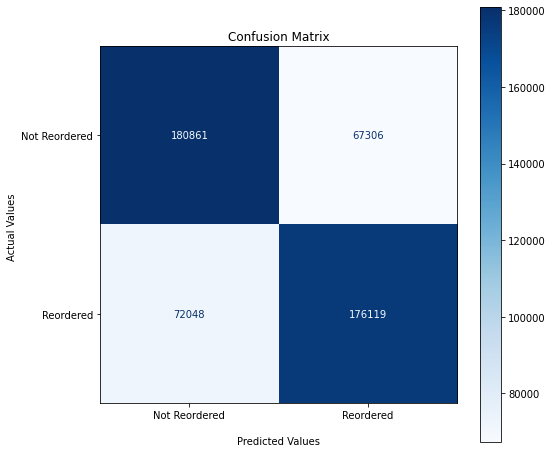

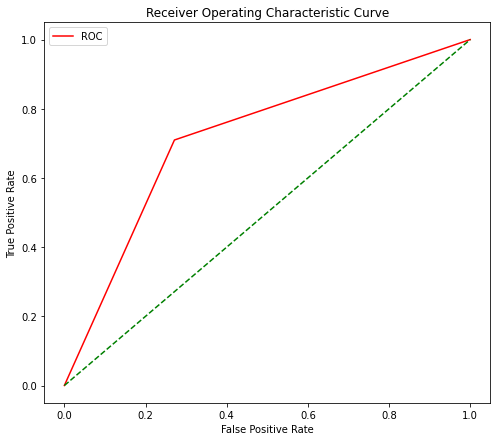

In [23]:
metrics(bestClassTree_pd)

confusion_matrix_plot(bestClassTree)

fper, tper, threshold = roc_curve(test_y, bestClassTree_pd)
plot_roc_curve(fper, tper)

## **Random Forest**

In [ ]:
rf = RandomForestClassifier()

rf.fit(train_x,train_y)

rf_predictions =rf.predict(test_x)

Accuracy: 72.4305%
Precision: 71.3999%
Recall: 72.9025%
F1 Score: 72.1434%
ROC AUC: 72.4400%


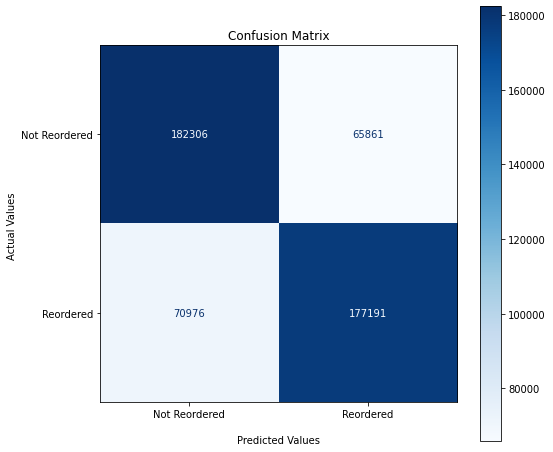

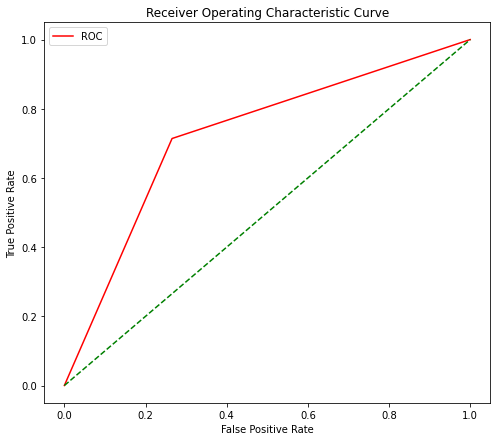

In [ ]:
metrics(rf_predictions)

confusion_matrix_plot(rf)

fper, tper, threshold = roc_curve(test_y, rf_predictions)
plot_roc_curve(fper, tper)

In [30]:
#increasing the number of estimators
rf_2 = RandomForestClassifier(n_estimators= 150)

rf_2.fit(train_x,train_y)

rf_2_predictions =rf_2.predict(test_x)

Accuracy: 72.6505%
Precision: 71.7549%
Recall: 73.0636%
F1 Score: 72.4033%
ROC AUC: 72.6577%


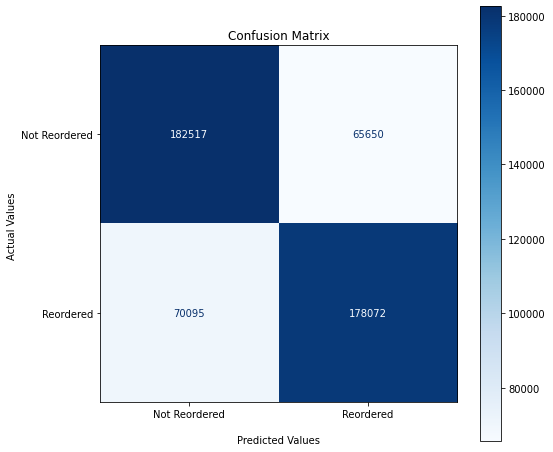

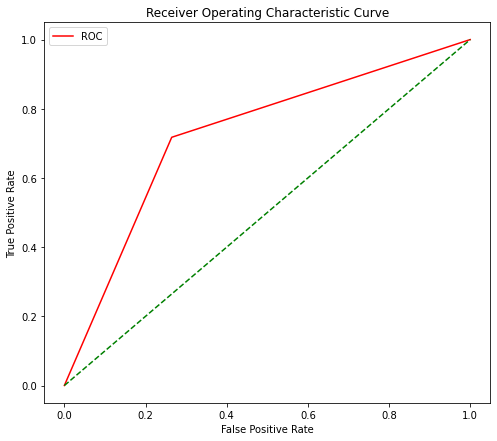

In [ ]:
metrics(rf_2_predictions)

confusion_matrix_plot(rf_2)

fper, tper, threshold = roc_curve(test_y, rf_2_predictions)
plot_roc_curve(fper, tper)

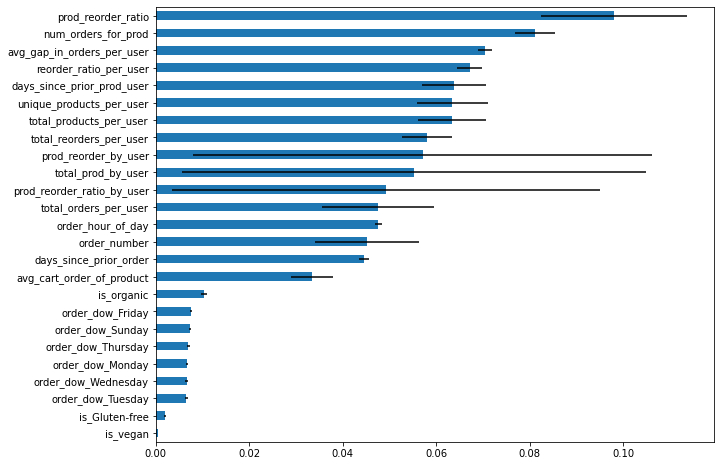

In [35]:
importances = rf_2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_2.estimators_], axis=0)
fp_plot = pd.DataFrame({'feature': train_x.columns, 'importance': importances, 'std': std})
fp_plot = fp_plot.sort_values('importance')
ax = fp_plot.plot(kind='barh', xerr='std', x='feature', legend=False, figsize=(10, 8) )
ax.set_ylabel('')
plt.show()

## **Logistic Regression**

In [32]:
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')

logit_reg.fit(train_x,train_y)

logit_predictions =logit_reg.predict(test_x)

Accuracy: 70.7554%
Precision: 67.7935%
Recall: 72.0623%
F1 Score: 69.8627%
ROC AUC: 70.8285%


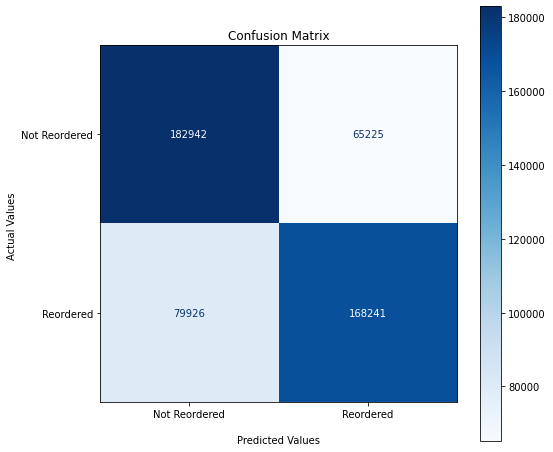

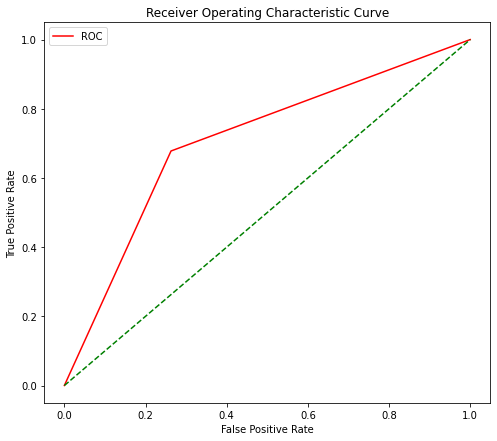

In [ ]:
metrics(logit_predictions)

confusion_matrix_plot(logit_reg)

fper, tper, threshold = roc_curve(test_y, logit_predictions)
plot_roc_curve(fper, tper)

##**Gradient Boosting**

Accuracy: 72.3684%
Precision: 70.7624%
Recall: 73.1107%
F1 Score: 71.9174%
ROC AUC: 72.3915%


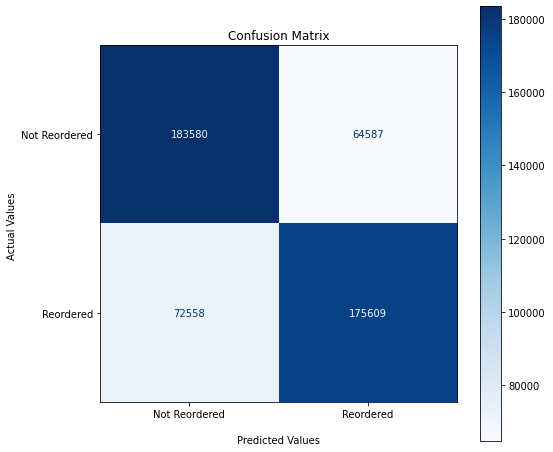

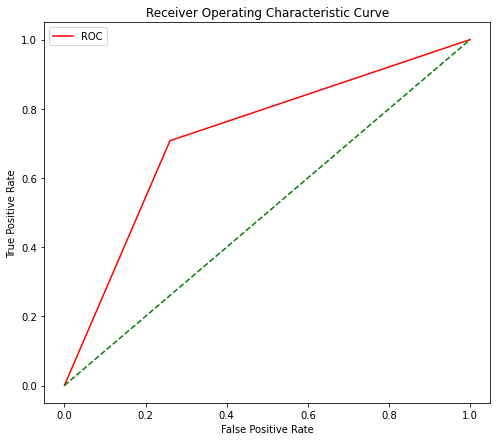

In [40]:
import xgboost as xgb

clf_bs = xgb.XGBClassifier()

clf_bs.fit(train_x,train_y)

clf_bs_predictions =clf_bs.predict(test_x)

metrics(clf_bs_predictions)

confusion_matrix_plot(clf_bs)

fper, tper, threshold = roc_curve(test_y, clf_bs_predictions)
plot_roc_curve(fper, tper)

In [ ]:

clf= xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'logloss', colsample_bytree = 0.7, learning_rate = 0.1,
                max_depth = 6, subsample = 0.7, gamma = 0, reg_lambda = 5.0, n_estimators = 400)

clf.fit(train_x,train_y)

clf_predictions =clf.predict(test_x) 

In [ ]:
#prediction on training set
classificationSummary(train_y, clf.predict(train_x))

Confusion Matrix (Accuracy 0.7333)

       Prediction
Actual      0      1
     0 433326 147331
     1 162378 418279


Accuracy: 72.7365%
Precision: 71.6489%
Recall: 73.2421%
F1 Score: 72.4367%
ROC AUC: 72.7473%


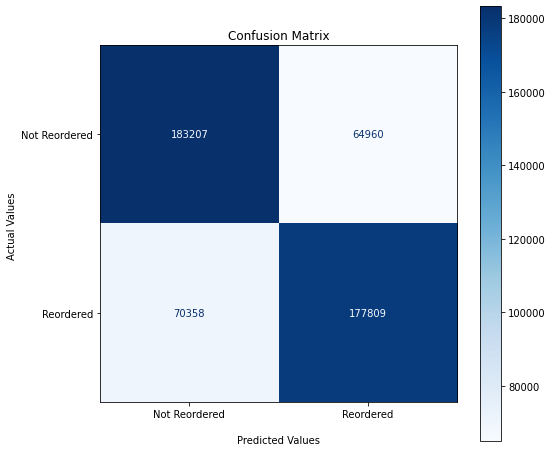

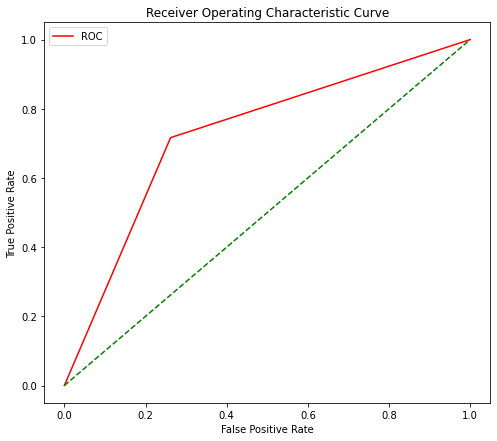

In [ ]:
metrics(clf_predictions)

confusion_matrix_plot(clf)

fper, tper, threshold = roc_curve(test_y, clf_predictions)
plot_roc_curve(fper, tper)

## **LightGBM**

In [ ]:
import lightgbm as lgb
  
l_gbm = lgb.LGBMClassifier()

l_gbm.fit(train_x,train_y)

l_gbm_predictions =l_gbm.predict(test_x) 

Accuracy: 72.5501%
Precision: 71.6006%
Recall: 72.9867%
F1 Score: 72.2870%
ROC AUC: 72.5583%


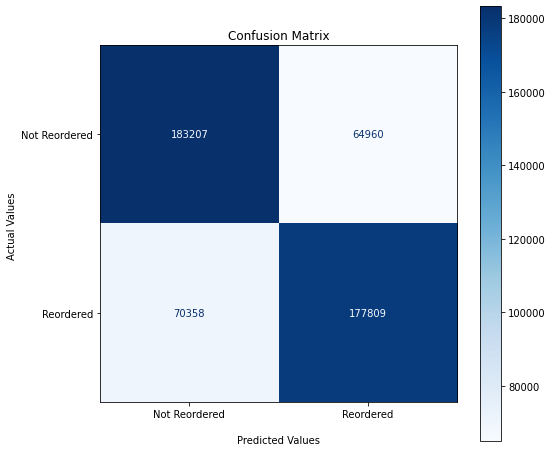

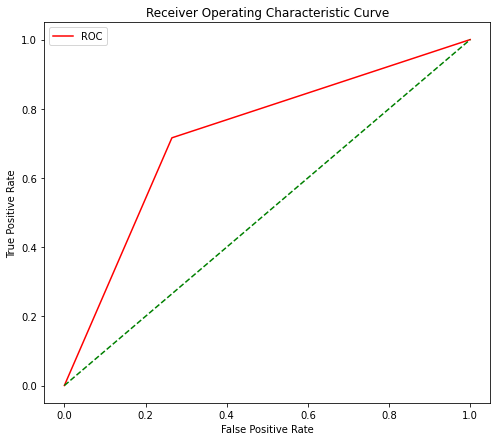

In [ ]:
metrics(l_gbm_predictions)

confusion_matrix_plot(clf)

fper, tper, threshold = roc_curve(test_y, l_gbm_predictions)
plot_roc_curve(fper, tper)

## **CatBoost**

In [41]:
!pip install catboost --quiet

import catboost 

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from catboost import CatBoostClassifier

cb = catboost.CatBoostClassifier()

cb.fit(train_x,train_y)

cb_predictions = cb.predict(test_x) 

In [43]:
cb.get_all_params()

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'class_names': [0, 1],
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'Logloss',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 10,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.2097329944372177,
 'loss_function': 'Logloss',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 0,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 '

Accuracy: 72.7546%
Precision: 71.5276%
Recall: 73.3271%
F1 Score: 72.4162%
ROC AUC: 72.7683%


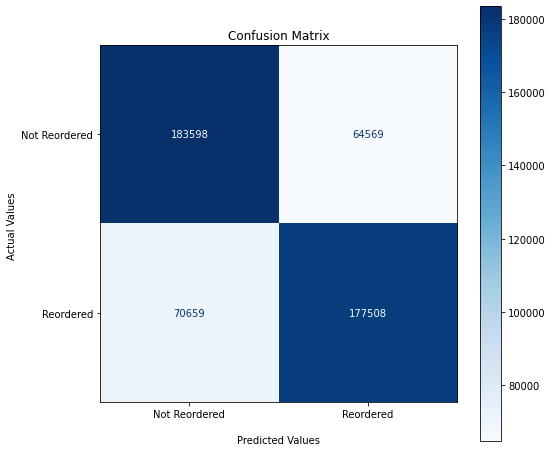

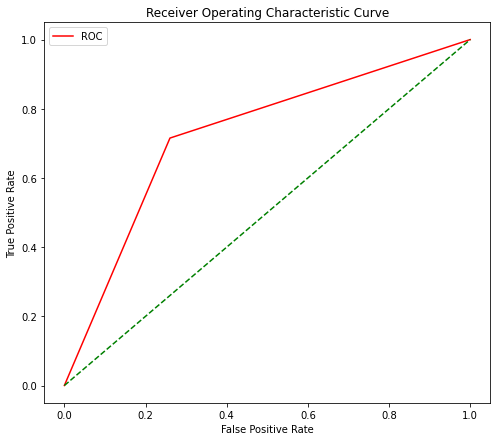

In [ ]:
metrics(cb_predictions)

confusion_matrix_plot(cb)

fper, tper, threshold = roc_curve(test_y, cb_predictions)
plot_roc_curve(fper, tper)

In [ ]:
grid = {'learning_rate': [0.2, 0.1, 0.3, 0.4],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'loss_function' : ['Logloss' , 'CrossEntropy']}

model = CatBoostClassifier()
randm = RandomizedSearchCV(estimator=model, param_distributions = grid, cv = 2, n_iter = 10, n_jobs=-1)
randm.fit(train_x, train_y)

In [45]:
# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n",randm.best_estimator_)
print("\n The best score across ALL searched params:\n",randm.best_score_)
print("\n The best parameters across ALL searched params:\n",randm.best_params_)
print("\n ========================================================")


 Results from Random Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.7268464859633139

 The best parameters across ALL searched params:
 {'loss_function': 'Logloss', 'learning_rate': 0.2, 'l2_leaf_reg': 5, 'depth': 4}



Accuracy: 72.6186%
Precision: 71.3785%
Recall: 73.1939%
F1 Score: 72.2748%
ROC AUC: 72.6326%


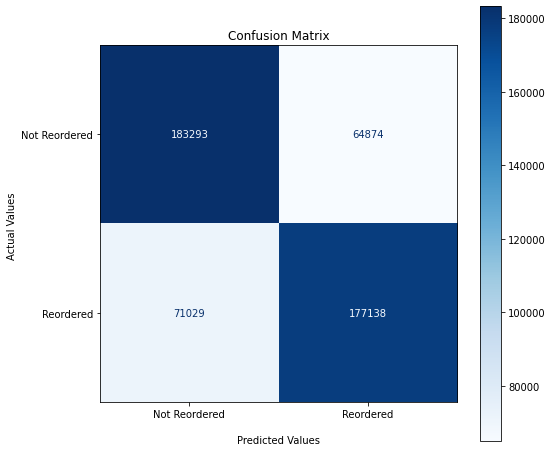

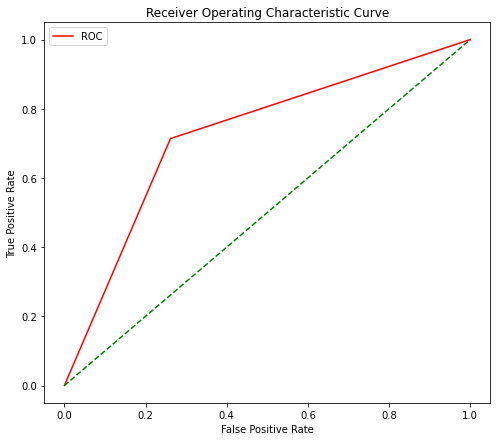

In [46]:
bestCatTree = randm.best_estimator_
bestCatTree_pd = bestCatTree.predict(test_x)

metrics(bestCatTree_pd)

confusion_matrix_plot(bestCatTree)

fper, tper, threshold = roc_curve(test_y, bestCatTree_pd)
plot_roc_curve(fper, tper)

## **Model Selection**

Both XGBoost and CatBoost classifiers performs better than rest of the models, with CatBoost with slightly higer accuracy. 

CatBoost Metrics:
* Accuracy: 72.7546%     
* Precision: 71.5276%
* Recall: 73.3271%
* F1 Score: 72.4162%
* ROC AUC: 72.7683%


**Cumulative Gain Chart and Lift Chart**

In [59]:
proba = cb.predict_proba(test_x)
result = pd.DataFrame({'actual': test_y,
                              'p(0)': [p[0] for p in proba],
                              'p(1)': [p[1] for p in proba],
                               'predicted': logit_predictions })

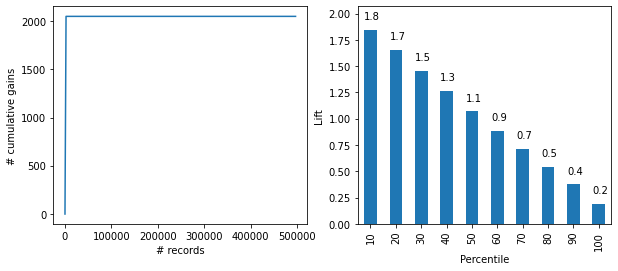

In [60]:
df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])

liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

The Lift Chart measures the effectiveness of models by calculating the ratio between the result obtained with a model and the result obtained without a model. 

10% of the records that are ranked by the model as "the most probable 1's" yields 1.8 times as many 1's as would a random selection of 10% of the records.

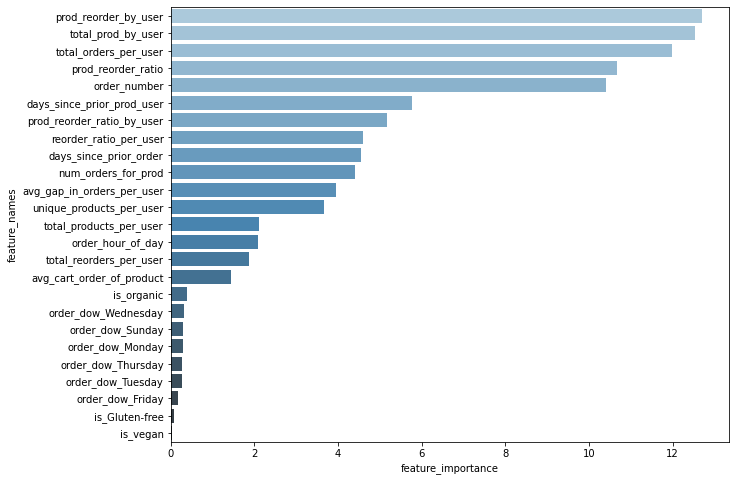

In [52]:
feature_importance = np.array(cb.get_feature_importance())
feature_names = np.array(train_x.columns)

data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette="Blues_d");

Top 5 features are:

* Number of reordered products by user
* Total number of products ordered by user
* Total number of orders by a user
* Reorder ratio of a product
* Order Number

CatBoost uses difference between the metric (Loss function) obtained using the model in normal scenario (when we include the feature) and model without this feature. 

As proposed by Lundberg and Lee, feature importance attribution methods should have:

* Consistency – if a model is changed so that it relies more on a particular feature, then the method must not attribute less importance to that feature; and
* Accuracy – the total contribution of each feature must sum up to the total contribution in the whole model


A model that satisfy both these conditions is SHAP (SHapley Additive exPlanation). SHAP is the average marginal contribution of a feature value across all the possible combinations of features. SHAP accounts for local importance of the feature.



In [10]:
import shap

In [53]:
explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(test_x)

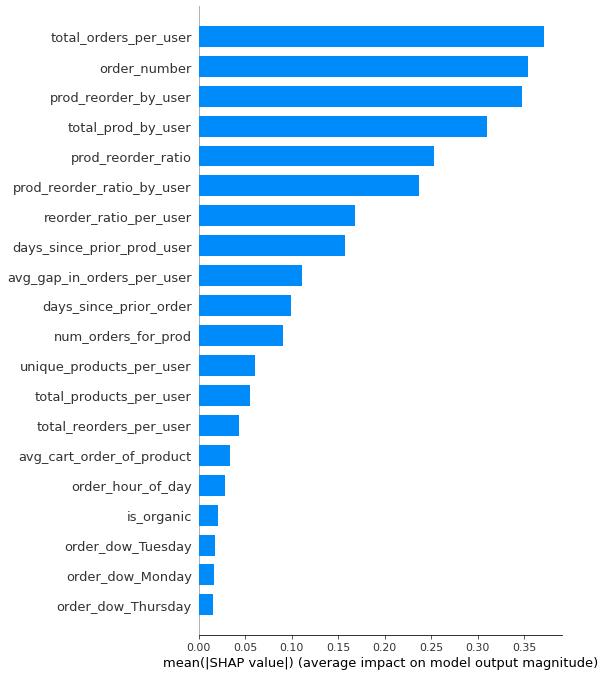

In [54]:
shap.summary_plot(shap_values, features= test_x, feature_names=test_x.columns, plot_type= 'bar')

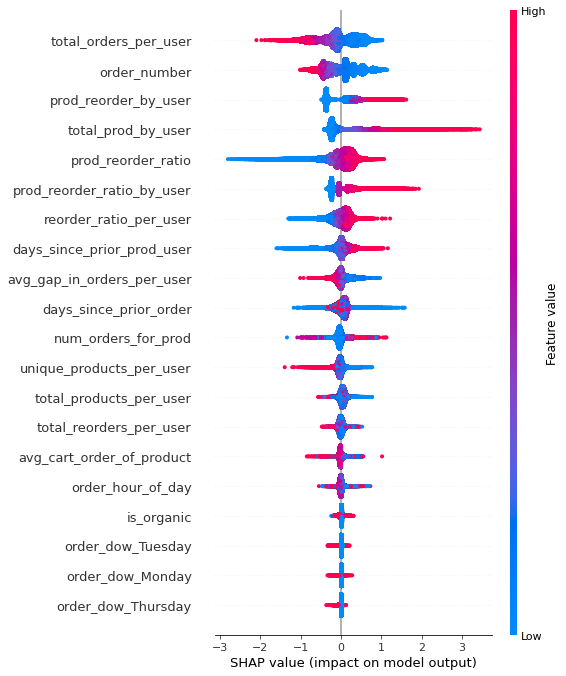

In [55]:
shap.summary_plot(shap_values, features= test_x, feature_names= test_x.columns)

Key findings:
* Large value of total_orders_per_user and order numbers have negative impact, which means a fairly new user will have more reordered products.
* While total product per user & product reorder ratio are not the top important features but they have huge impact on a subset of the users with low product reorder ratio having negative impact on the model and high value of total product per user having positive impact.
* Users with high reordered products have positive impact on the model.
* High reorder ratio of a product by a user will have positive impact on the model.